# Are Taylor Swift's songs too boring?

* This project was inspired by a conversation I had with someone that criticised Taylor Swift's songs had the same themes and use the same literary motifs.

* In this project, I aim to collect lyrics of songs performed by Taylor Swift to look into this.

In [16]:
import os
import json
from glob import glob
from PIL import Image
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import util

In [10]:
%load_ext autoreload
%autoreload 2

## Collecting our data

In [11]:
if not glob('tswizzle.json'):
    util.download_lyrics(os.environ['ACCESS_KEY'], 'Taylor Swift', 'tswizzle.json')

In [12]:
with open('tswizzle.json', 'r') as f:
    data = json.loads(f.read())

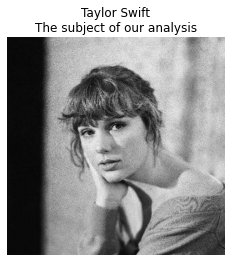

In [13]:
im = np.asarray(Image.open(requests.get(data['image_url'], stream=True).raw))
plt.imshow(im, vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.title(f"{data['name']}\nThe subject of our analysis")
plt.show()

## Preprocessing text data

In [14]:
df = util.load_lyrics(data)

func:load_lyrics took: 0:00:00.002067 sec


In [19]:
glove = util.load_embeddings("glove.6B.50d.txt")

Found 400000 word vectors.
load_embeddings(('glove.6B.50d.txt',),{}) took: 0:00:05.825121 sec


## NLTK Preprocessing

In [7]:
# Checks intersect of our vocabulary and GloVe sembeddings
# Outputs list of out of vocabulary of word

import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [14]:
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


def handle_contractions(x):
    tb_tokenizer = TreebankWordTokenizer()
    x = tb_tokenizer.tokenize(x)
    return ' '.join(x)

def preprocess(text, keep_hashtags=True):
    text = handle_contractions(text)
    tokenizer = TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True)
    tokens = tokenizer.tokenize(text)
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    l = []

    for token in tokens:
        if token[0] == "#" and not keep_hashtags:
            continue
        if token[:4] == "http":
            continue
        if token.isnumeric() or not token[0].isalpha():
            continue
        if token[0] == "@":
            continue
        if token in stop_words:
            continue

        if "'" in token:
            l.append(ps.stem(token.lower()))
        else:
            l.append(ps.stem(token.lower()))
    return " ".join(l)

In [15]:
vocab = build_vocab(list(songs_df['lyrics'].apply(lambda x: preprocess(x).split())))
oov = check_coverage(vocab, glove_embeddings)
oov[:10]

100%|██████████| 4885/4885 [00:00<00:00, 838757.78it/s]

Found embeddings for 73.41% of vocab
Found embeddings for  90.75% of all text


[('everyth', 210),
 ('everi', 206),
 ('littl', 189),
 ('someth', 182),
 ('realli', 148),
 ('leav', 128),
 ('peopl', 119),
 ('beauti', 118),
 ('someon', 116),
 ('danc', 115)]

In [20]:
# TODO: Build some wordcloud showing commonly used words in Taylor Swift songs
import wordcloud

words = []
for word, count in vocab.items():
    words.extend([word] * count)
words = ' '.join(words)
    
words = wordcloud.WordCloud().process_text(words)
wcloud = wordcloud.WordCloud().generate(' '.join(words))

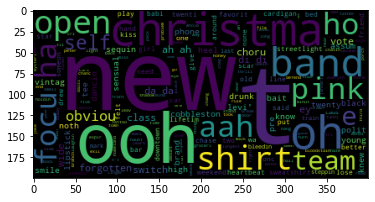

In [21]:
import matplotlib.pyplot as plt

plt.imshow(wcloud)
plt.show()

## spaCy Preprocessing

In [43]:
import spacy

nlp = spacy.load('en_core_web_sm')

text = ' '.join([' '.join(s.lower().split('\n')) for s in songs_df['lyrics']])

doc = nlp(text)

In [47]:
# Analyze syntax
# print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
# print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts

for entity in np.unique(doc.ents):
    print(entity.text, entity.label_)

two CARDINAL
twenty CARDINAL
five whole minutes TIME
second ORDINAL
third ORDINAL
hundredth CARDINAL
20 seconds TIME
20 years DATE
three CARDINAL
each night TIME
sunday DATE
today DATE
another day DATE
one CARDINAL
only seventeen CARDINAL
only seventeen CARDINAL
weeks DATE
only seventeen CARDINAL
first ORDINAL
one CARDINAL
first ORDINAL
first ORDINAL
4th ORDINAL
four CARDINAL
first ORDINAL
first ORDINAL
first ORDINAL
first ORDINAL
first ORDINAL
first ORDINAL
summer DATE
winter DATE
1 CARDINAL
2 CARDINAL
3 CARDINAL
1 CARDINAL
2 DATE
3 CARDINAL
all night TIME
first ORDINAL
first ORDINAL
a weekend DATE
mm PERSON
a month DATE
second ORDINAL
mm PERSON
mm PERSON
night TIME
the good years DATE
november DATE
two CARDINAL
'90s DATE
first ORDINAL
three-year DATE
american NORP
one CARDINAL
the afternoon TIME
fifty years DATE
third ORDINAL
months DATE
one CARDINAL
one CARDINAL
one CARDINAL
late november TIME
summer DATE
seven feet QUANTITY
the summer DATE
the summer DATE
india GPE
just one CARDINA